In [300]:
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import time

In [56]:
X_train = mnist.train.images
y_train = mnist.train.labels.astype("int")

X_test = mnist.test.images
y_test = mnist.test.labels.astype("int")

In [165]:
def display_matrix(X, row=None, size=28):
    X_data = np.array([])
    if row is None:
        row = np.sqrt(len(X))
    for x in X:
        arr = x.reshape(size,size)
        if X_data.any() :
            X_data = np.concatenate( (X_data, arr), axis=1  )
        else:
            X_data = arr
    n = np.array_split(X_data, row, axis=1)
    X_data = np.concatenate(n, axis=0)
    plt.imshow(X_data, interpolation="nearest", cmap=plt.get_cmap('gray'))
    plt.axis("off")
    plt.show()

In [149]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes(""%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    
    # If no input graph is given, get the default graph
    if graph_def is None:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)

### RNN 0-4

In [158]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [127]:
tf.reset_default_graph()

In [128]:
n_hidden = 100
n_input = 28*28
n_outputs = 5
lr = 0.001
n_epochs = 150

In [129]:
X = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [130]:
he_init = tf.contrib.layers.variance_scaling_initializer() # Initialisation de He
hidden1 = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, name="hidden1", kernel_initializer=he_init)
hidden2 = tf.layers.dense(hidden1, n_hidden, activation=tf.nn.elu, name="hidden2", kernel_initializer=he_init)
hidden3 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.elu, name="hidden3", kernel_initializer=he_init)
hidden4 = tf.layers.dense(hidden3, n_hidden, activation=tf.nn.elu, name="hidden4", kernel_initializer=he_init)
hidden5 = tf.layers.dense(hidden4, n_hidden, activation=tf.nn.elu, name="hidden5", kernel_initializer=he_init)

logits = tf.layers.dense(hidden5, n_outputs, activation=tf.nn.elu, name="logits", kernel_initializer=he_init)
y_proba = tf.nn.softmax(logits, name="Y_proba")

In [131]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)  # entropie croisée
loss = tf.reduce_mean(xentropy, name="loss")  # loss


optimizer = tf.train.AdamOptimizer(lr, name="optimiserAdmin")
training_op = optimizer.minimize(loss, name="Adam1")


with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [132]:
index_X_train_0_4 = [ idx for idx, val in enumerate(y_train) if val < 5 ]
index_X_valid_0_4 = [ idx for idx, val in enumerate(y_valid) if val < 5 ]
index_X_test_0_4 = [ idx for idx, val in enumerate(y_test) if val < 5 ]

In [133]:
X_train_04 = X_train[index_X_train_0_4]
y_train_04 = y_train[index_X_train_0_4]
X_valid_04 = X_valid[index_X_valid_0_4]
y_valid_04 = y_valid[index_X_valid_0_4]
X_test_04 = X_test[index_X_test_0_4]
y_test_04 = y_test[index_X_test_0_4]

In [134]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [135]:
acc_t = []
acc_v = []
loss_a = []
with tf.device("/gpu:0"):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        init.run()
        for epoch in range(n_epochs):
            sess.run(training_op, feed_dict={X: X_train_04, y: y_train_04})
            acc_batch = accuracy.eval(feed_dict={X: X_train_04, y: y_train_04})
            acc_valid = accuracy.eval(feed_dict={X: X_valid_04, y: y_valid_04})
            if epoch % 5 == 0:
                print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
            acc_t.append(acc_batch)
            acc_v.append(acc_valid)
            loss_a.append(loss.eval(feed_dict={X: X_train_04, y: y_train_04}))
        saver.save(sess, "save/RNP04/mymodel04")

0 Batch accuracy: 0.375098 Validation accuracy: 0.358092
5 Batch accuracy: 0.872851 Validation accuracy: 0.877639
10 Batch accuracy: 0.928704 Validation accuracy: 0.933933
15 Batch accuracy: 0.942721 Validation accuracy: 0.944488
20 Batch accuracy: 0.955097 Validation accuracy: 0.956607
25 Batch accuracy: 0.960375 Validation accuracy: 0.962471
30 Batch accuracy: 0.965654 Validation accuracy: 0.965989
35 Batch accuracy: 0.969078 Validation accuracy: 0.969117
40 Batch accuracy: 0.971004 Validation accuracy: 0.97068
45 Batch accuracy: 0.972573 Validation accuracy: 0.97068
50 Batch accuracy: 0.974784 Validation accuracy: 0.972244
55 Batch accuracy: 0.976354 Validation accuracy: 0.97459
60 Batch accuracy: 0.977816 Validation accuracy: 0.97498
65 Batch accuracy: 0.979492 Validation accuracy: 0.977717
70 Batch accuracy: 0.980562 Validation accuracy: 0.977326
75 Batch accuracy: 0.981418 Validation accuracy: 0.977717
80 Batch accuracy: 0.982381 Validation accuracy: 0.977717
85 Batch accuracy: 0

In [114]:
with tf.Session() as sess:
    saver.restore(sess, "save/RNP04/mymodel04")
    accuracy_val = accuracy.eval(feed_dict={X: X_test_04, y: y_test_04})
    print(accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP04/mymodel04
0.989103


In [115]:
with tf.Session() as sess:
    saver.restore(sess, "save/RNP04/mymodel04")
    Z = logits.eval(feed_dict={X:[X_test_04[10]]})
    pred = np.argmax(Z, axis=1)
    print(pred)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP04/mymodel04
[4]


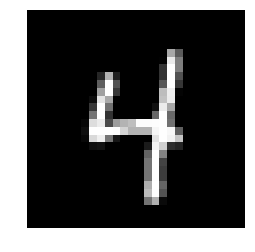

In [42]:
display_matrix(X_test_04[10:11])

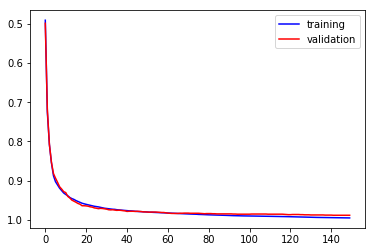

In [116]:
ax = plt.gca()
ax.invert_yaxis()
plt.plot(acc_t, "b", label="training")
plt.plot(acc_v, 'r', label="validation")
plt.legend()
plt.show()

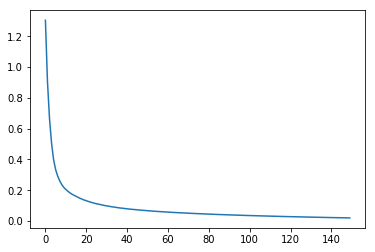

In [117]:
plt.plot(loss_a)
plt.show()

## with batch normalisation

In [81]:
n_epochs = 150

casi identique sans BN, except que la bn doit etre calculé avant la fonction d'activation. Donc calculer hidden puis BN puis activation

In [82]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

he_init = tf.contrib.layers.variance_scaling_initializer() # Initialisation de He


hidden1 = tf.layers.dense(X, n_hidden, name="hiddenbn1", kernel_initializer=he_init)
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9) # mommentum = constante de lissage (1-n)
bn1_act = tf.nn.elu(bn1)


hidden2 = tf.layers.dense(bn1_act, n_hidden, name="hiddenbn2", kernel_initializer=he_init)
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

hidden3 = tf.layers.dense(bn2_act, n_hidden, name="hiddenbn3", kernel_initializer=he_init)
bn3 = tf.layers.batch_normalization(hidden3, training=training, momentum=0.9)
bn3_act = tf.nn.elu(bn3)

hidden4 = tf.layers.dense(bn3_act, n_hidden, name="hiddenbn4", kernel_initializer=he_init)
bn4 = tf.layers.batch_normalization(hidden4, training=training, momentum=0.9)
bn4_act = tf.nn.elu(bn4)

hidden5 = tf.layers.dense(bn4_act, n_hidden, name="hiddenbn5", kernel_initializer=he_init)
bn5 = tf.layers.batch_normalization(hidden5, training=training, momentum=0.9)
bn5_act = tf.nn.elu(bn5)

logit_before_bn = tf.layers.dense(bn5_act, n_outputs, name="logitsbn", kernel_initializer=he_init)
logits = tf.layers.batch_normalization(logit_before_bn, training=training, momentum=0.9)


xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)  # entropie croisée
loss = tf.reduce_mean(xentropy, name="loss")  # loss


optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(loss)


with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [83]:
acc_t = []
acc_v = []
loss_a = []

phase de training est identique a un RN classique à deux exception : 
- lors de l'evaluation d'une operation qui depend d'un BN, il faut fixer la valeur du placeholder training à True
- la fonction tf.layers.batch_normalisation(..) crée plusieurs operations qui doivent etre evalusé à chaque iteration, pour ça ajouter la ligne :
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
et la foutre dans le run de chaque iteration.

In [84]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run([training_op, extra_update_ops], feed_dict={training:True,X: X_train_04, y: y_train_04})
        acc_batch = accuracy.eval(feed_dict={X: X_train_04, y: y_train_04})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_04, y: y_valid_04})
        #if epoch % 5 == 0:
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        acc_t.append(acc_batch)
        acc_v.append(acc_valid)
        loss_a.append(loss.eval(feed_dict={X: X_train_04, y: y_train_04}))
    saver.save(sess, "save/RNP04/mymodel04-bn")

0 Batch accuracy: 0.360796 Validation accuracy: 0.387021
1 Batch accuracy: 0.551323 Validation accuracy: 0.565676
2 Batch accuracy: 0.720023 Validation accuracy: 0.713057
3 Batch accuracy: 0.830658 Validation accuracy: 0.829554
4 Batch accuracy: 0.877773 Validation accuracy: 0.883112
5 Batch accuracy: 0.902418 Validation accuracy: 0.909695
6 Batch accuracy: 0.91886 Validation accuracy: 0.923769
7 Batch accuracy: 0.929667 Validation accuracy: 0.933542
8 Batch accuracy: 0.936657 Validation accuracy: 0.939406
9 Batch accuracy: 0.942328 Validation accuracy: 0.944879
10 Batch accuracy: 0.946216 Validation accuracy: 0.947615
11 Batch accuracy: 0.949247 Validation accuracy: 0.951525
12 Batch accuracy: 0.95153 Validation accuracy: 0.953479
13 Batch accuracy: 0.953492 Validation accuracy: 0.955043
14 Batch accuracy: 0.954312 Validation accuracy: 0.955434
15 Batch accuracy: 0.955382 Validation accuracy: 0.955434
16 Batch accuracy: 0.956167 Validation accuracy: 0.955434
17 Batch accuracy: 0.95684

142 Batch accuracy: 0.990477 Validation accuracy: 0.985927
143 Batch accuracy: 0.990549 Validation accuracy: 0.985927
144 Batch accuracy: 0.99062 Validation accuracy: 0.985927
145 Batch accuracy: 0.99062 Validation accuracy: 0.985927
146 Batch accuracy: 0.990656 Validation accuracy: 0.986317
147 Batch accuracy: 0.990763 Validation accuracy: 0.985927
148 Batch accuracy: 0.991084 Validation accuracy: 0.985927
149 Batch accuracy: 0.991155 Validation accuracy: 0.985927


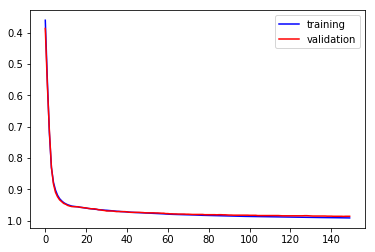

In [103]:
ax = plt.gca()
ax.invert_yaxis()
plt.plot(acc_t, "b", label="training")
plt.plot(acc_v, 'r', label="validation")
plt.legend()
plt.show()

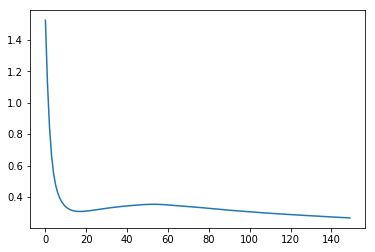

In [87]:
plt.plot(loss_a)
plt.show()

In [212]:
with tf.Session() as sess:
    saver.restore(sess, "save/RNP04/mymodel04")
    accuracy_val = accuracy.eval(feed_dict={X: X_test_04, y: y_test_04})
    print(accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP04/mymodel04
0.987352





Le modele converge plus vite que la version sans le BN. Leger surajustement (0.991155 training 0.985927 validation).

Le modele gagne aussi 1% de precision

### With dropout

In [13]:
n_epochs = 250

pour ajouter dropout, appliquer fonction tf.layers.dropout() à la sortie de chaque couche (sauf la couche de sortie). tf.nn.drop() est active tot le temps, même aprés entrainement donc vaut mieux utiliser tf.layers.dropout().

In [14]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

dropout_rate = 0.5
he_init = tf.contrib.layers.variance_scaling_initializer() # Initialisation de He

X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden, name="hiddenbn1", kernel_initializer=he_init)
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9) # mommentum = constante de lissage (1-n)
bn1_act = tf.nn.elu(bn1)

hidden1_drop = tf.layers.dropout(bn1_act, dropout_rate, training=training)

hidden2 = tf.layers.dense(hidden1_drop, n_hidden, name="hiddenbn2", kernel_initializer=he_init)
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

hidden2_drop = tf.layers.dropout(bn2_act, dropout_rate, training=training)

hidden3 = tf.layers.dense(hidden2_drop, n_hidden, name="hiddenbn3", kernel_initializer=he_init)
bn3 = tf.layers.batch_normalization(hidden3, training=training, momentum=0.9)
bn3_act = tf.nn.elu(bn3)

hidden3_drop = tf.layers.dropout(bn3_act, dropout_rate, training=training)

hidden4 = tf.layers.dense(hidden3_drop, n_hidden, name="hiddenbn4", kernel_initializer=he_init)
bn4 = tf.layers.batch_normalization(hidden4, training=training, momentum=0.9)
bn4_act = tf.nn.elu(bn4)

hidden4_drop = tf.layers.dropout(bn4_act, dropout_rate, training=training)

hidden5 = tf.layers.dense(hidden4_drop, n_hidden, name="hiddenbn5", kernel_initializer=he_init)
bn5 = tf.layers.batch_normalization(hidden5, training=training, momentum=0.9)
bn5_act = tf.nn.elu(bn5)

hidden5_drop = tf.layers.dropout(bn5_act, dropout_rate, training=training)

logit_before_bn = tf.layers.dense(hidden5_drop, n_outputs, name="logitsbn", kernel_initializer=he_init)
logits = tf.layers.batch_normalization(logit_before_bn, training=training, momentum=0.9)


xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)  # entropie croisée
loss = tf.reduce_mean(xentropy, name="loss")  # loss


optimizer = tf.train.AdamOptimizer(lr)
training_op = optimizer.minimize(loss)


with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [19]:
acc_t_d = []
acc_v_d = []
loss_a_d = []

In [20]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run([training_op, extra_update_ops], feed_dict={training:True, X: X_train_04, y: y_train_04})
        acc_batch = accuracy.eval(feed_dict={X: X_train_04, y: y_train_04})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_04, y: y_valid_04})
        #if epoch % 5 == 0:
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        acc_t_d.append(acc_batch)
        acc_v_d.append(acc_valid)
        loss_a_d.append(loss.eval(feed_dict={X: X_train_04, y: y_train_04}))
    saver.save(sess, "save/RNP04/mymodel04-bn-dropout")

0 Batch accuracy: 0.514088 Validation accuracy: 0.493745
1 Batch accuracy: 0.661923 Validation accuracy: 0.641517
2 Batch accuracy: 0.72869 Validation accuracy: 0.71853
3 Batch accuracy: 0.769491 Validation accuracy: 0.763878
4 Batch accuracy: 0.79863 Validation accuracy: 0.792416
5 Batch accuracy: 0.822776 Validation accuracy: 0.812744
6 Batch accuracy: 0.839967 Validation accuracy: 0.829554
7 Batch accuracy: 0.856124 Validation accuracy: 0.850665
8 Batch accuracy: 0.87039 Validation accuracy: 0.866302
9 Batch accuracy: 0.882053 Validation accuracy: 0.879202
10 Batch accuracy: 0.893181 Validation accuracy: 0.889758
11 Batch accuracy: 0.901776 Validation accuracy: 0.897967
12 Batch accuracy: 0.908731 Validation accuracy: 0.906959
13 Batch accuracy: 0.913189 Validation accuracy: 0.910477
14 Batch accuracy: 0.917219 Validation accuracy: 0.915559
15 Batch accuracy: 0.920215 Validation accuracy: 0.918296
16 Batch accuracy: 0.92232 Validation accuracy: 0.920641
17 Batch accuracy: 0.924353 V

142 Batch accuracy: 0.962872 Validation accuracy: 0.95817
143 Batch accuracy: 0.962907 Validation accuracy: 0.95817
144 Batch accuracy: 0.962979 Validation accuracy: 0.95817
145 Batch accuracy: 0.962943 Validation accuracy: 0.95817
146 Batch accuracy: 0.962979 Validation accuracy: 0.95817
147 Batch accuracy: 0.963086 Validation accuracy: 0.95817
148 Batch accuracy: 0.963193 Validation accuracy: 0.95817
149 Batch accuracy: 0.963335 Validation accuracy: 0.95817
150 Batch accuracy: 0.963371 Validation accuracy: 0.95817
151 Batch accuracy: 0.963407 Validation accuracy: 0.95817
152 Batch accuracy: 0.963549 Validation accuracy: 0.958561
153 Batch accuracy: 0.963621 Validation accuracy: 0.958561
154 Batch accuracy: 0.963656 Validation accuracy: 0.958952
155 Batch accuracy: 0.963692 Validation accuracy: 0.958952
156 Batch accuracy: 0.963799 Validation accuracy: 0.958952
157 Batch accuracy: 0.963906 Validation accuracy: 0.958952
158 Batch accuracy: 0.964049 Validation accuracy: 0.958952
159 Bat

In [127]:
with tf.Session() as sess:
    saver.restore(sess, "save/RNP04/mymodel04-bn-dropout")
    accuracy_val = accuracy.eval(feed_dict={X: X_test_04, y: y_test_04})
    print(accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP04/mymodel04-bn-dropout
0.96692


Dropout n'ameliore pas le model. Donc vaut mieux economiser du temps et train le modele sans dropout

# Transfert d'apprentissage

Charger le graph :

In [342]:
tf.reset_default_graph()
saver_59 = tf.train.import_meta_graph("save/RNP04/mymodel04.meta")

recuperer référence operations / tenseurs : 

In [343]:
graph = tf.get_default_graph()

In [344]:
X = graph.get_tensor_by_name("X:0")
y = graph.get_tensor_by_name("y:0")

loss = graph.get_tensor_by_name("loss:0")
Y_proba = graph.get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]

accuracy = graph.get_tensor_by_name("eval/accuracy:0")

On fige toutes les couches sauf la couches logits

In [345]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(lr, name="adam")
training_op = optimizer.minimize(loss, var_list=train_vars, name="adam")

In [346]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [347]:
init = tf.global_variables_initializer()
saver_new_59 = tf.train.Saver()

on recupere juste les chiffres de 5 a 9 

In [295]:
index_X_train_5_9 = [ idx for idx, val in enumerate(y_train) if val >= 5 ]
index_X_valid_5_9 = [ idx for idx, val in enumerate(y_valid) if val >= 5 ]
index_X_test_5_9 = [ idx for idx, val in enumerate(y_test) if val >= 5 ]
X_train_59 = X_train[index_X_train_5_9]
y_train_59 = y_train[index_X_train_5_9]
X_valid_59 = X_valid[index_X_valid_5_9]
y_valid_59 = y_valid[index_X_valid_5_9]
X_test_59 = X_test[index_X_test_5_9]
y_test_59 = y_test[index_X_test_5_9]

Et on va prendre que 100 images par class afin de voir combien d'accuracy on peut atteindre avec un petit dataset

In [296]:
def sample_100_by_class(X, y, m=100):
    ck = {5:[], 6:[], 7:[], 8:[], 9:[]}
    for i, v in enumerate(y):
        if len(ck[v]) < m :
            ck[v].append(i)
    res = np.concatenate((ck[5],ck[6],ck[7],ck[8],ck[9]))
    return shuffle(res)

In [348]:
index_X_train_5_9_100 = sample_100_by_class(X_train_59, y_train_59)
index_X_valid_5_9_30 = sample_100_by_class(X_valid_59, y_valid_59, 30)
index_X_test_5_9_30 = sample_100_by_class(X_test_59, y_test_59, 30)
X_train_59_100 = X_train_59[index_X_train_5_9_100]
y_train_59_100 = y_train_59[index_X_train_5_9_100] - 5
X_valid_59_100 = X_valid_59[index_X_valid_5_9_30]
y_valid_59_100 = y_valid_59[index_X_valid_5_9_30] - 5
X_test_59_100 = X_test_59[index_X_test_5_9_30]
y_test_59_100 = y_test_59[index_X_test_5_9_30] - 5

training

In [335]:
n_epochs = 300
acc_t_1 = []
acc_v_1 = []
loss_a_1 = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    init.run()
    
    saver_59.restore(sess, "save/RNP04/mymodel04")
    for var in train_vars:
        var.initializer.run()
    t0 = time.time()
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict={X: X_train_59_100, y: y_train_59_100})
        acc_batch = accuracy.eval(feed_dict={X: X_train_59_100, y: y_train_59_100})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_59_100, y: y_valid_59_100})
        if epoch % 10 == 0:
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
        #acc_t_1.append(acc_batch)
        #acc_v_1.append(acc_valid)
        #loss_a_1.append(loss.eval(feed_dict={X: X_train_59_100, y: y_train_59_100}))
    saver.save(sess, "save/RNP59/mymodel")
    
    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP04/mymodel04
0 Batch accuracy: 0.17 Validation accuracy: 0.186667
10 Batch accuracy: 0.272 Validation accuracy: 0.24
20 Batch accuracy: 0.39 Validation accuracy: 0.366667
30 Batch accuracy: 0.49 Validation accuracy: 0.546667
40 Batch accuracy: 0.562 Validation accuracy: 0.64
50 Batch accuracy: 0.638 Validation accuracy: 0.653333
60 Batch accuracy: 0.66 Validation accuracy: 0.673333
70 Batch accuracy: 0.698 Validation accuracy: 0.68
80 Batch accuracy: 0.734 Validation accuracy: 0.68
90 Batch accuracy: 0.748 Validation accuracy: 0.693333
100 Batch accuracy: 0.762 Validation accuracy: 0.733333
110 Batch accuracy: 0.774 Validation accuracy: 0.726667
120 Batch accuracy: 0.786 Validation accuracy: 0.733333
130 Batch accuracy: 0.79 Validation accuracy: 0.74
140 Batch accuracy: 0.796 Validation accuracy: 0.76
150 Batch accuracy: 0.808 Validation accuracy: 0.766667
160 Batch accuracy: 0.816 Validation acc

In [308]:
with tf.Session() as sess:
    saver.restore(sess, "save/RNP59/mymodel")
    accuracy_val = accuracy.eval(feed_dict={X: X_test_59_100, y: y_test_59_100})
    print(accuracy_val)

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP59/mymodel
0.84


84% max d'accuracity sur le test dataset, 80% sur le validation data set et 90% sur le training dataset.
le modele a l'air de surajusté et les donner et le petit dataset empeche d'avoir une bonne accuracy

= > 2,9 sec pour epoch

On test en mettant en cache les couches figés maintenant 

In [349]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5/Elu:0")

In [351]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    init.run()
    
    saver_59.restore(sess, "save/RNP04/mymodel04")
    for var in train_vars:
        var.initializer.run()
        
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train_59_100, y: y_train_59_100})
    
    for epoch in range(n_epochs):
        sess.run(training_op, feed_dict={hidden5_out: hidden5_train, y: y_train_59_100})
        acc_batch = accuracy.eval(feed_dict={X: X_train_59_100, y: y_train_59_100})
        acc_valid = accuracy.eval(feed_dict={X: X_valid_59_100, y: y_valid_59_100})
        if epoch % 10 == 0:
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid) 
    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

INFO:tensorflow:Restoring parameters from /Users/yannis/Developpement/DeepLearning/save/RNP04/mymodel04
0 Batch accuracy: 0.23 Validation accuracy: 0.22
10 Batch accuracy: 0.354 Validation accuracy: 0.266667
20 Batch accuracy: 0.436 Validation accuracy: 0.373333
30 Batch accuracy: 0.464 Validation accuracy: 0.406667
40 Batch accuracy: 0.474 Validation accuracy: 0.413333
50 Batch accuracy: 0.496 Validation accuracy: 0.433333
60 Batch accuracy: 0.546 Validation accuracy: 0.486667
70 Batch accuracy: 0.588 Validation accuracy: 0.56
80 Batch accuracy: 0.65 Validation accuracy: 0.626667
90 Batch accuracy: 0.694 Validation accuracy: 0.646667
100 Batch accuracy: 0.744 Validation accuracy: 0.693333
110 Batch accuracy: 0.772 Validation accuracy: 0.706667
120 Batch accuracy: 0.782 Validation accuracy: 0.746667
130 Batch accuracy: 0.804 Validation accuracy: 0.76
140 Batch accuracy: 0.812 Validation accuracy: 0.76
150 Batch accuracy: 0.82 Validation accuracy: 0.753333
160 Batch accuracy: 0.824 Vali

=> Avec les couches figés en cache, le temps de training descend à 1,5sec, soit deux plus rapide que sans cache.